In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import models.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import warnings
warnings.filterwarnings("ignore")

TSNEing


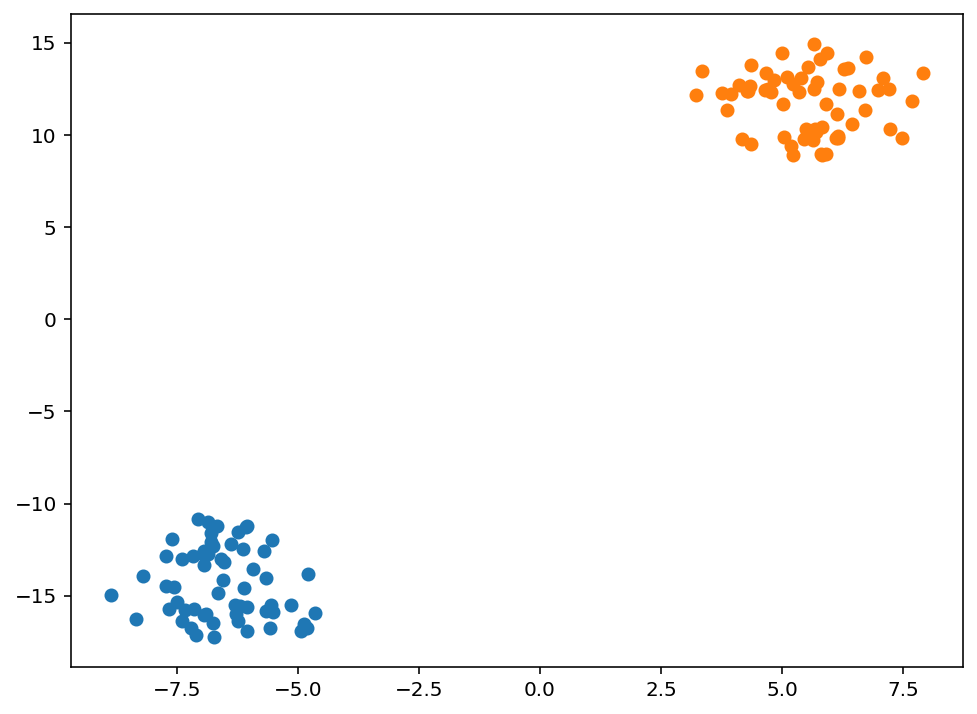

In [63]:
import utils.plot_data as plot
train_embeds = pickle.load(open("embeds/bm/prolific/bm_prolific_d512_e50/pre_no_aug_0/MTL1/MTL_han_train_emb512_s4.pkl","rb"))
y_train = [0]*60+[1]*60
_ = plot.plot_data(train_embeds,y_train)

In [55]:

required_args = \
["gpus", "seed", "dataloader_num_workers", "model","check_val_every_n_epoch",
"max_epochs", "learning_rate", "train_batch_size", "embed_dim",
"num_class" ,"train_dir", "valid_dir", "test_dir", "transform", "aug",
"wandb_group", "wandb_mode", "wandb_project", "wandb_entity",  "wandb_name",
"do_train", "do_test", "checkpoint_callback", "enable_progress_bar", "log_every_n_steps",
"train_triplets", "valid_triplets", "test_triplets", "triplet_batch_size",
"pretrained", "lamda", "syn", "embeds_output_dir", "deterministic", "test_ckpt_path","out_csv"]
wandb_args = ["wandb_group", "wandb_mode", "wandb_project", "wandb_entity",  "wandb_name"]
trainer_args = ["gpus", "seed",  "deterministic", "dataloader_num_workers",
    "do_train", "do_test", "checkpoint_callback", "enable_progress_bar", "log_every_n_steps"]
training_args = ["max_epochs", "learning_rate","check_val_every_n_epoch",
    "train_batch_size", "triplet_batch_size"]
dataset_args = ["train_dir", "valid_dir", "test_dir", "transform", "aug", "num_class", "syn"]
triplet_args = ["train_triplets", "valid_triplets", "test_triplets"]
model_args = ["model", "embed_dim","pretrained", "lamda"]
file_args = ["embeds_output_dir", "test_ckpt_path","out_csv"]

In [56]:
all = wandb_args + trainer_args + training_args + dataaset_args + triplets_args + model_args + file_args

In [57]:
np.setdiff1d(required_args, all)

array([], dtype='<U23')

## synthetic features.pkl

In [143]:
df = pd.read_csv("datasets/wv_3d/df.csv")
features = ["head size","body size","tail size","texture"]

In [158]:
files = utils.dataset_filenames("datasets/wv_3d/train")
files = [x.split("/")[-1] for x in files[:,0]]
train_features = np.array([list(df[df["img_id"]==f][features].iloc[0]) for f in files])

In [160]:
files = utils.dataset_filenames("datasets/wv_3d/test")
files = [x.split("/")[-1] for x in files[:,0]]
test_features = np.array([list(df[df["img_id"]==f][features].iloc[0]) for f in files])

## generated alignments

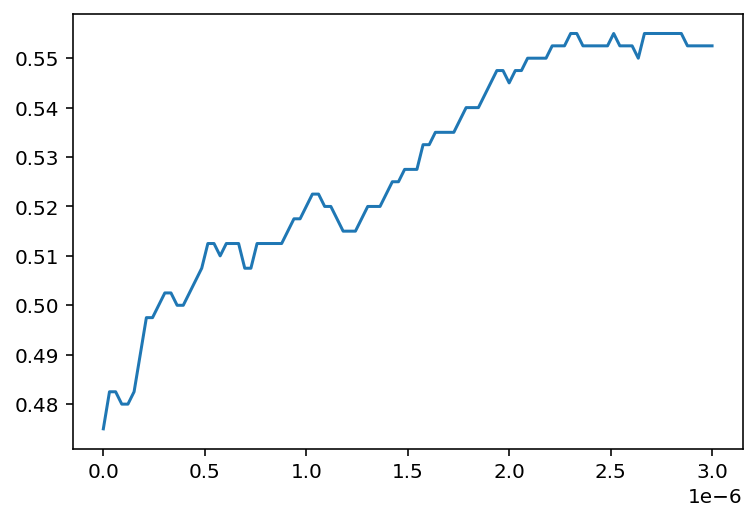

In [26]:
df = pd.read_csv("data_gen/search.csv")
plt.plot(df["weights"],df["aligns"])

In [31]:
df.iloc[13]["weights"]

3.93939393939394e-07

In [44]:
pd.DataFrame({"a":[1]})

,a
0,1


In [39]:
import pandas as pd
df =  pd.DataFrame()
df.to_csv("models/results/wv_3d.csv",index=False)

In [59]:
pd.read_csv("models/results/wv_3d.csv")

,wandb_project,wandb_group,wandb_name,seed,weights,embed_dim,lamda,test_clf_acc,test_triplet_acc,test_1nn_acc,...,h2h_512,NINO_ds_acc_k=1,rNINO_ds_acc_k=1,NIFO_ds_acc_k=1,NINO_ds_acc_k=3,rNINO_ds_acc_k=3,NIFO_ds_acc_k=3,NINO_ds_acc_k=5,rNINO_ds_acc_k=5,NIFO_ds_acc_k=5


In [30]:
np.where(df["aligns"]==0.5)

(array([ 9, 12, 13]),)

In [4]:
train_embeds = pickle.load(open("datasets/wv_3d/train_features.pkl","rb"))
test_embeds = pickle.load(open("datasets/wv_3d/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/train")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/test")])

In [40]:
len(list(itertools.product(np.arange(8),repeat=4)))

4096

(array([  65.,   17.,   32.,   56.,   31.,  367., 1265.,  427.,  354.,
        1483.]),
 array([0.46 , 0.514, 0.568, 0.622, 0.676, 0.73 , 0.784, 0.838, 0.892,
        0.946, 1.   ]),
 <BarContainer object of 10 artists>)

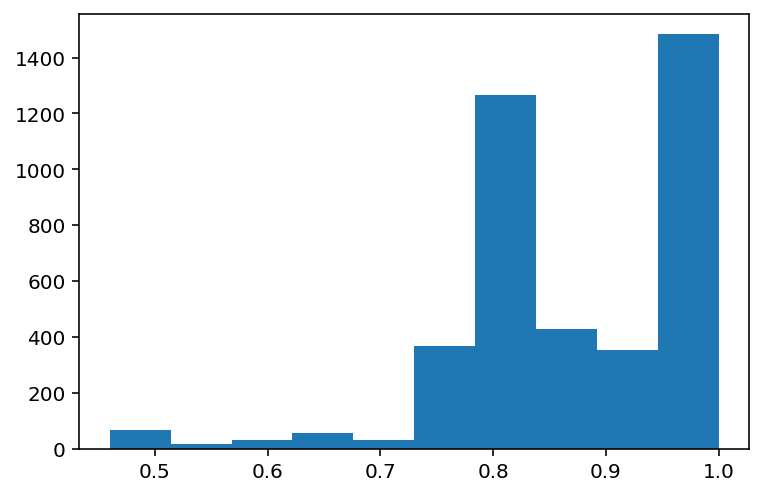

In [55]:
df = pd.read_csv("data_gen/grid.csv")
plt.hist(df["aligns"])

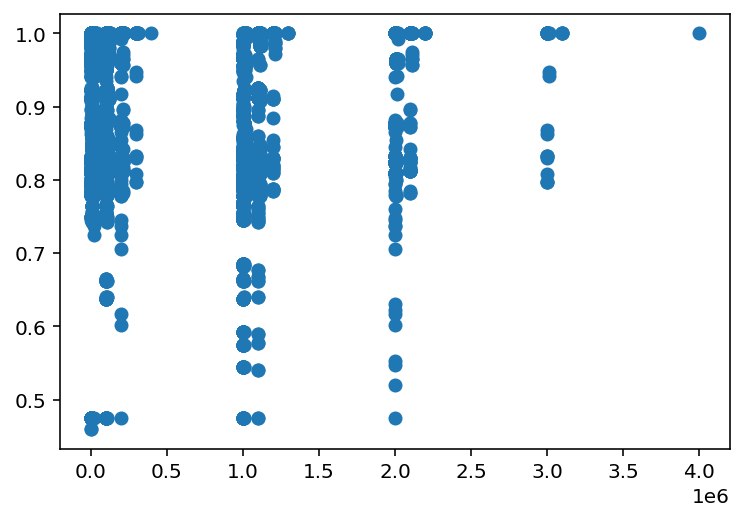

In [57]:
weight_sums = [sum([int(x) for x in df["weights"][i].replace("(","").replace(")","").split(",")]) for i in range(4097)]
plt.scatter(weight_sums,df["aligns"])

(array([  64.,    0.,    0.,    0.,    0.,  127.,  769.,    0.,    0.,
        3136.]),
 array([0.46 , 0.514, 0.568, 0.622, 0.676, 0.73 , 0.784, 0.838, 0.892,
        0.946, 1.   ]),
 <BarContainer object of 10 artists>)

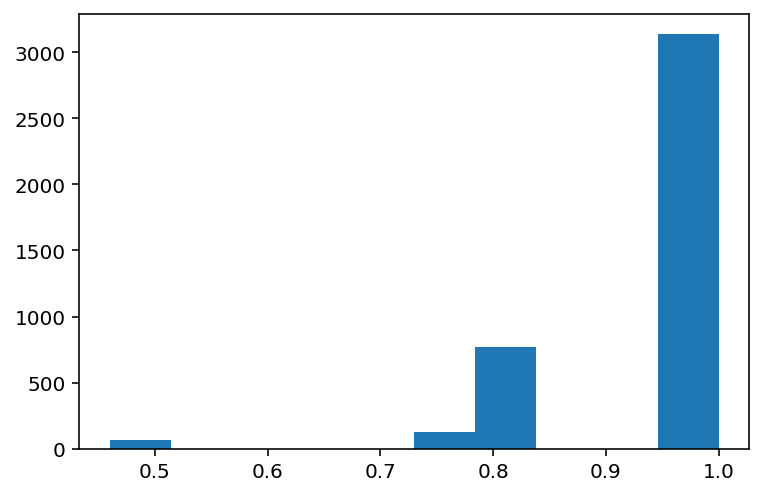

In [2]:
df = pd.read_csv("data_gen/powers_2.csv")
plt.hist(df["aligns"])

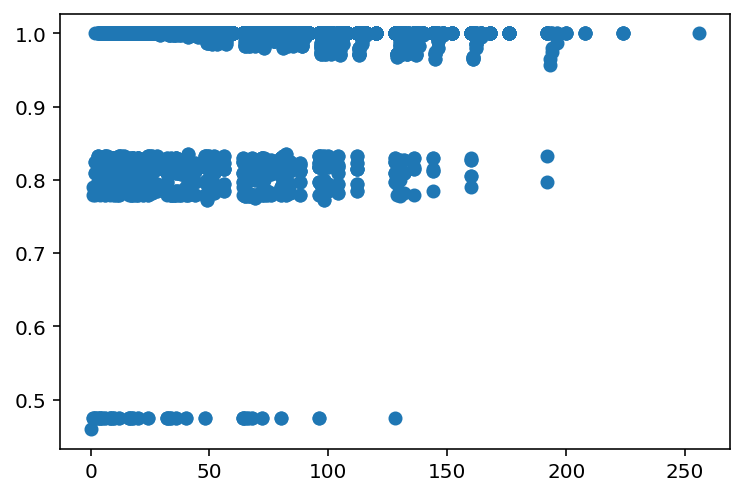

In [3]:
weight_sums = [sum([int(x) for x in df["weights"][i].replace("(","").replace(")","").split(",")]) for i in range(4096)]
plt.scatter(weight_sums,df["aligns"])

In [18]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [1,0,1,1])

0.7975

In [9]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [0,1,1,1])

0.8325

In [22]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [1,256,256,256])

0.92

In [14]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [0,0,1,1])


0.475

In [19]:
df[df["aligns"]==0.9575]

,Unnamed: 0,Unnamed: 0.1,weights,aligns
1023,NaN,NaN,"(1, 64, 64, 64)",0.9575


In [10]:
np.unique(df["aligns"])

array([0.46  , 0.475 , 0.7725, 0.775 , 0.7775, 0.78  , 0.7825, 0.785 ,
       0.79  , 0.7925, 0.795 , 0.7975, 0.8   , 0.8025, 0.805 , 0.8075,
       0.81  , 0.8125, 0.815 , 0.8175, 0.82  , 0.8225, 0.825 , 0.8275,
       0.83  , 0.8325, 0.835 , 0.9575, 0.965 , 0.9675, 0.97  , 0.9725,
       0.975 , 0.9775, 0.98  , 0.9825, 0.985 , 0.9875, 0.99  , 0.9925,
       0.995 , 0.9975, 1.    ])

### triplet gen

In [23]:
train_features = pickle.load(open("datasets/wv_3d/train_features.pkl","rb"))
valid_features = pickle.load(open("datasets/wv_3d/valid_features.pkl","rb"))
test_features = pickle.load(open("datasets/wv_3d/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/train")])
y_valid = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/valid")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/test")])

In [26]:
weights = [
    [0,0,1,1],
    [1,0,1,1],
    [0,1,1,1],
    [1,256,256,256],
    [256,1,256,256],
    [1,1,1,1]
]
aligns = [0.5,0.8,0.83,0.92,0.925,1]
total = 30000
triplet_dir = "datasets/wv_3d_triplets/new"

In [27]:

for weight,align in zip(weights, aligns):
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weight, total)
    print(len(train_triplets_filtered)/len(train_triplets), len(valid_triplets_filtered)/len(valid_triplets), len(test_triplets_filtered)/len(test_triplets))
    # break
    align_dir = os.path.join(triplet_dir,f"align={str(align)}")
    if not os.path.isdir(align_dir): os.mkdir(align_dir)
    pickle.dump(train_triplets, open(f"{align_dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{align_dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{align_dir}/test_triplets.pkl", "wb"))
    pickle.dump(train_triplets_filtered, open(f"{align_dir}/train_triplets_filtered.pkl","wb"))
    pickle.dump(valid_triplets_filtered, open(f"{align_dir}/valid_triplets_filtered.pkl","wb"))
    pickle.dump(test_triplets_filtered, open(f"{align_dir}/test_triplets_filtered.pkl","wb"))

0.75225 0.7513333333333333 0.7366666666666667
0.7659166666666667 0.762 0.77
0.76725 0.7571666666666667 0.7766666666666666
0.7684166666666666 0.772 0.7688333333333334
0.7636568190341264 0.7771666666666667 0.7708333333333334
0.7676666666666667 0.7735 0.7715


In [8]:
w2s = [0,0.00075,0.002693,0.011,1]
aligns = [0.8,0.85,0.9,0.95,1]
total = 30000

triplet_dir = "datasets/wv_3d_triplets"
for w2,align in zip(w2s, aligns):
    weights = [1,w2,1,1] 
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weights, total)
    print(len(train_triplets_filtered)/len(train_triplets), len(valid_triplets_filtered)/len(valid_triplets), len(test_triplets_filtered)/len(test_triplets))
    # break
    align_dir = os.path.join(triplet_dir,f"align={str(align)}")
    if not os.path.isdir(align_dir): os.mkdir(align_dir)
    pickle.dump(train_triplets, open(f"{align_dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{align_dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{align_dir}/test_triplets.pkl", "wb"))
    pickle.dump(train_triplets_filtered, open(f"{align_dir}/train_triplets_filtered.pkl","wb"))
    pickle.dump(valid_triplets_filtered, open(f"{align_dir}/valid_triplets_filtered.pkl","wb"))
    pickle.dump(test_triplets_filtered, open(f"{align_dir}/test_triplets_filtered.pkl","wb"))

0.7647083333333333 0.77 0.771
0.7625833333333333 0.772 0.7685
0.7645833333333333 0.766 0.7741666666666667
0.7639166666666667 0.775 0.7708333333333334
0.7710833333333333 0.7821666666666667 0.7741666666666667


In [9]:
train_triplets = pickle.load(open("datasets/wv_3d_triplets/align=0.8/train_triplets.pkl","rb"))
valid_triplets = pickle.load(open("datasets/wv_3d_triplets/align=0.8/valid_triplets.pkl","rb"))
test_triplets = pickle.load(open("datasets/wv_3d_triplets/align=0.8/test_triplets.pkl","rb"))
for p in [0.05,0.1, 0.2, 0.3, 0.4, 0.5]:
    dir = os.path.join("datasets/wv_3d_triplets/align=0.8_noisy",str(p))
    if not os.path.isdir(dir): os.mkdir(dir)
    train_noisy = gen.get_noisy_triplets(train_triplets, p)
    valid_noisy = gen.get_noisy_triplets(valid_triplets, p)
    test_noisy = gen.get_noisy_triplets(test_triplets, p)
    pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
    pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
    pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [8]:
w1s = [0, 3.94e-07, 2.64e-06,9.61e-06,2.56e-05,4.8e-05,1.28e-03]
aligns = [0.475,0.5,0.55,0.6,0.65,0.7,0.75]

total = 30000
triplet_dir = "datasets/wv_3d_triplets"
for w1,align in zip(w2s, aligns):
    weights = [w1,0,1,1] 
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weights, total)
    print(len(train_triplets_filtered)/len(train_triplets), len(valid_triplets_filtered)/len(valid_triplets), len(test_triplets_filtered)/len(test_triplets))
    # break
    align_dir = os.path.join(triplet_dir,f"align={str(align)}")
    if not os.path.isdir(align_dir): os.mkdir(align_dir)
    pickle.dump(train_triplets, open(f"{align_dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{align_dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{align_dir}/test_triplets.pkl", "wb"))
    pickle.dump(train_triplets_filtered, open(f"{align_dir}/train_triplets_filtered.pkl","wb"))
    pickle.dump(valid_triplets_filtered, open(f"{align_dir}/valid_triplets_filtered.pkl","wb"))
    pickle.dump(test_triplets_filtered, open(f"{align_dir}/test_triplets_filtered.pkl","wb"))

0.7541666666666667 0.7435 0.7435
0.751 0.7591666666666667 0.7586666666666667
0.7507083333333333 0.754 0.7488333333333334
0.7520416666666667 0.749 0.7406666666666667
0.7579482478436601 0.7456666666666667 0.7486666666666667
0.748 0.7585 0.737
0.7459477478228259 0.7441666666666666 0.7576666666666667


## yaml generation

In [28]:
yaml_dir = "models/configs/wv_3d/align_triplets"
base = oc.load(f"{yaml_dir}/align=0.5.yaml")
for weight,align in zip(weights, aligns):
    train_triplets = base.train_triplets.replace("0.5",str(align))
    valid_triplets = base.valid_triplets.replace("0.5",str(align))
    test_triplets = base.test_triplets.replace("0.5",str(align))
    wandb_group = base.wandb_group.replace("0.5",str(align))
    overwrite = {"weights":weight, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base,overwrite), f"models/configs/wv_3d/align_triplets/align={align}.yaml")

In [31]:
base_filtered = oc.load(f"{yaml_dir}/align=0.8_filtered.yaml")
for weight,align in zip(weights, aligns):
    train_triplets = base_filtered.train_triplets.replace("0.8",str(align))
    valid_triplets = base_filtered.valid_triplets.replace("0.8",str(align))
    test_triplets = base_filtered.test_triplets.replace("0.8",str(align))
    wandb_group = base_filtered.wandb_group.replace("0.8",str(align))
    overwrite = {"weights":weight, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_filtered,overwrite), f"models/configs/wv_3d/align_triplets/align={align}_filtered.yaml")

In [2]:
yaml_dir = "models/configs/wv_3d/align_triplets"
base = oc.load(f"{yaml_dir}/align=0.8.yaml")
w1s = [0, 3.94e-07, 2.64e-06,9.61e-06,2.56e-05,4.8e-05,1.28e-03] + [1]*4
w2s = [0]*7 + [0,0.0008,0.003,0.0123,1]
aligns = [0.475,0.5,0.55,0.6,0.65,0.7,0.75] + [0.8,0.85,0.9,0.95,1] 

In [48]:
for w1, w2, align in zip(w1s, w2s, aligns):
    weights = [w1,w2,1,1] 
    train_triplets = base.train_triplets.replace("0.8",str(align))
    valid_triplets = base.valid_triplets.replace("0.8",str(align))
    test_triplets = base.test_triplets.replace("0.8",str(align))
    wandb_group = base.wandb_group.replace("0.8",str(align))
    overwrite = {"weights":weights, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base,overwrite), f"models/configs/wv_3d/align_triplets/align={align}.yaml")

In [49]:
yaml_dir = "models/configs/wv_3d/filtered_triplets"
base_filtered = oc.load(f"{yaml_dir}/align=0.8_filtered.yaml")

In [50]:
for w1, w2, align in zip(w1s, w2s, aligns):
    weights = [w1,w2,1,1] 
    train_triplets = base_filtered.train_triplets.replace("0.8",str(align))
    valid_triplets = base_filtered.valid_triplets.replace("0.8",str(align))
    test_triplets = base_filtered.test_triplets.replace("0.8",str(align))
    wandb_group = base_filtered.wandb_group.replace("0.8",str(align))
    overwrite = {"weights":weights, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_filtered,overwrite), f"models/configs/wv_3d/filtered_triplets/align={align}_filtered.yaml")

In [98]:
yaml_dir = "models/configs/wv_3d/noisy_triplets"
base_noisy = oc.load(f"{yaml_dir}/noise=0.1.yaml")

In [99]:
for p in [0.1, 0.05,0.2, 0.3, 0.4, 0.5]:
    train_triplets = base_noisy.train_triplets.replace("0.1",str(p))
    valid_triplets = base_noisy.valid_triplets.replace("0.1",str(p))
    test_triplets = base_noisy.test_triplets.replace("0.1",str(p))
    wandb_group = base_noisy.wandb_group.replace("0.1",str(p))
    overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_noisy,overwrite), f"models/configs/wv_3d/noisy_triplets/noise={p}.yaml")